In [115]:
#ポケモン画像2x2モザイクのRGB取得
import dataset
image = dataset.Data_set()

In [116]:
#説明変数XとタイプのみのYに分離
import pandas as pd
import random
poke = pd.read_csv('data/convert_data/Pokemon.csv')
poke_noType = poke.drop(['Number','Type1','Type2','Total','HP','Attack','Defense','SpecialAtk','SpecialDef','Speed','Generation','Legendary'],axis=1)
X = []
Y = []
l = len(poke)
col = poke_noType.columns.values
coll = len(col)
index = 0
while index < l:
    column = 0
    Xdata = []
    Y_nt = []
    while column < coll: 
        Xdata.append(poke_noType.iat[index,column])
        column += 1
        
    Y_nt.append(poke.at[index,'Type1'])
    #タイプ2が無い場合タイプ1をコピー ex.['Fire','']なら['Fire','Fire']
    if type(poke.at[index,'Type2']) is not type(poke.at[index,'Type1']):
        Y_nt.append(poke.at[index,'Type1'])
    else:
        Y_nt.append(poke.at[index,'Type2'])
    X.append(Xdata)
    Y.append(Y_nt)
    index += 1

In [117]:
#Xにモザイクデータつける
pon = 0 #0~ポケモン数
while pon < l:
    til = 0 #0~3 タイル4つ分
    while til < 4:
        rgb = 0 #0~2 rgb3つ分
        while rgb < 3:
            X[pon].append(image[pon][til][rgb])
            rgb += 1
        til += 1
    pon += 1

In [118]:
#どっちか当たってればいい精度確認関数
def acjapan(Y_test, Y_pred1, Y_pred2):
    testlen = len(Y_test) #テストポケモン数
    acn = 0
    true = 0
    while acn < testlen:
        if Y_pred1[acn] == Y_test[acn][0] or Y_pred1[acn] == Y_test[acn][1] or Y_pred2[acn] == Y_test[acn][0] or Y_pred2[acn] == Y_test[acn][1]:
            true += 1
        acn += 1

    acc = true/testlen
    return acc

In [119]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split # trainとtest分割用

# train用とtest用のデータ用意。test_sizeでテスト用データの割合を指定。random_stateはseed値を適当にセット。
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size = 0.2, random_state=0)

#第1~7世代はtrainに,第8世代はtestに(第8世代予測用)
# (X_train, X_test, Y_train, Y_test) = (X[0:801], X[801:], Y[0:801], Y[801:])
# for i in [X_train, Y_train]:
#     random.seed(32)
#     random.shuffle(i)

#Xには["名前"、重さ、RGB,...,RGB]が入ってるので名前だけ別のlistに移す(学習に名前は使わない + 後に名前と予測タイプをprintして見たいため)
#Yには["タイプ1","タイプ2"]が入ってるのでタイプ1のlist,タイプ2のlistをそれぞれ作る
Name = []
X_train2 = X_train
X_test2 = X_test
Y_train_t1 = []
Y_train_t2 = []
train0 = 0
test0 = 0
trainl = len(X_train2) #train数
testl = len(X_test2) #test数

while train0 < trainl:
    X_train2[train0].pop(0)
    Y_train_t1.append(Y_train[train0][0])
    Y_train_t2.append(Y_train[train0][1])
    train0 += 1

while test0 < testl:
    Name.append(X_test2[test0].pop(0))
    test0 += 1

In [120]:
#標準化。重さとRGBの数値を揃える(極端な重さは鋼と岩に分類しやすくなるからイランかも)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train2)
X_test_std = sc.fit_transform(X_test2)

In [121]:
#パラメータ探しの旅
#n_neighbors: Kの数
#weights: 重み付け。dagoultは'uniform'で全ての値が等しく考慮される。'distance'は距離も関係(遠い場所より近い場所の値が優先されたりする)
#p:ミンコフスキー距離。defaultはp=2でユークリッド距離のこと。ついでにp=1はマンハッタン距離
param_gs_knn ={'n_neighbors':[11,31,51,71],
               'weights':['uniform','distance'],
               'p':[1,2,3,4,5,6,7,8,9,10]}

In [122]:
#パラメータ探しの旅NEXT
from sklearn.model_selection import GridSearchCV
knn = KNeighborsClassifier() # インスタンス生成

grid_search1 = GridSearchCV(knn, param_gs_knn, cv=5)
grid_search1.fit(X_train2, Y_train_t1) #標準化無し タイプ1学習

grid_search2 = GridSearchCV(knn, param_gs_knn, cv=5)
grid_search2.fit(X_train2, Y_train_t2) #標準化無し タイプ2学習

grid_search3 = GridSearchCV(knn, param_gs_knn, cv=5)
grid_search3.fit(X_train_std, Y_train_t1) #標準化有り タイプ1学習

grid_search4 = GridSearchCV(knn, param_gs_knn, cv=5)
grid_search4.fit(X_train_std, Y_train_t2) #標準化有り タイプ2学習

/Users/e175768/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/e175768/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [11, 31, 51, 71], 'weights': ['uniform', 'distance'], 'p': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [130]:
print("標準化無し","\nbest_param1:",grid_search1.best_params_,"best_score1:",grid_search1.best_score_,"\nbest_param2:",grid_search2.best_params_,"best_score2:",grid_search2.best_score_)
print("標準化有り","\nbest_param1:",grid_search3.best_params_,"best_score1:",grid_search3.best_score_,"\nbest_param2:",grid_search4.best_params_,"best_score2:",grid_search4.best_score_)

標準化無し 
best_param1: {'n_neighbors': 71, 'p': 2, 'weights': 'distance'} best_score1: 0.21560283687943263 
best_param2: {'n_neighbors': 51, 'p': 2, 'weights': 'distance'} best_score2: 0.1702127659574468
標準化有り 
best_param1: {'n_neighbors': 71, 'p': 10, 'weights': 'distance'} best_score1: 0.22695035460992907 
best_param2: {'n_neighbors': 51, 'p': 1, 'weights': 'distance'} best_score2: 0.15460992907801419


In [124]:
#試しに学習してみる
k = 1 #kの数
p = 1 #パラメータp

#目的変数 = タイプ1 の場合
knn1 = KNeighborsClassifier(n_neighbors=k, weights="distance", p=p)
knn1.fit(X_train2, Y_train_t1)                # モデル作成実行
Y_pred1 = knn1.predict(X_test2)           # 予測実行

#目的変数 = タイプ2 の場合
knn2 = KNeighborsClassifier(n_neighbors=k, weights="distance", p=p)
knn2.fit(X_train2, Y_train_t2)
Y_pred2 = knn2.predict(X_test2)

#精度の確認
accuracy = acjapan(Y_test,Y_pred1,Y_pred2)
print("accuracy=",accuracy)

accuracy= 0.22033898305084745


In [125]:
#名前、タイプ、予測タイプ1、予測タイプ2をprintで確認
test0 = 0
while test0 < testl:
    print("名前:",Name[test0]," 実タイプ:",Y_test[test0]," 予測タイプ1:",Y_pred1[test0]," 予測タイプ2:", Y_pred2[test0])
    test0 += 1

名前: Mew  実タイプ: ['Psychic', 'Psychic']  予測タイプ1: Normal  予測タイプ2: Normal
名前: Roserade  実タイプ: ['Grass', 'Poison']  予測タイプ1: Rock  予測タイプ2: Ice
名前: Simisear  実タイプ: ['Fire', 'Fire']  予測タイプ1: Fire  予測タイプ2: Fire
名前: Exeggcute  実タイプ: ['Grass', 'Psychic']  予測タイプ1: Grass  予測タイプ2: Fairy
名前: Deerling  実タイプ: ['Normal', 'Grass']  予測タイプ1: Steel  予測タイプ2: Steel
名前: Dedenne  実タイプ: ['Electric', 'Fairy']  予測タイプ1: Fire  予測タイプ2: Fire
名前: Corviknight  実タイプ: ['Flying', 'Steel']  予測タイプ1: Rock  予測タイプ2: Rock
名前: Coalossal  実タイプ: ['Rock', 'Fire']  予測タイプ1: Rock  予測タイプ2: Dragon
名前: Starly  実タイプ: ['Normal', 'Flying']  予測タイプ1: Grass  予測タイプ2: Grass
名前: Nidoran♂  実タイプ: ['Poison', 'Poison']  予測タイプ1: Poison  予測タイプ2: Poison
名前: Umbreon  実タイプ: ['Dark', 'Dark']  予測タイプ1: Psychic  予測タイプ2: Flying
名前: Heatran  実タイプ: ['Fire', 'Steel']  予測タイプ1: Steel  予測タイプ2: Ground
名前: Monferno  実タイプ: ['Fire', 'Fighting']  予測タイプ1: Fire  予測タイプ2: Fighting
名前: Silicobra  実タイプ: ['Ground', 'Ground']  予測タイプ1: Normal  予測タイプ2: Normal
名前: Electivire  実タイプ: 

名前: Walrein  実タイプ: ['Ice', 'Water']  予測タイプ1: Ground  予測タイプ2: Rock
名前: Centiskorch  実タイプ: ['Fire', 'Bug']  予測タイプ1: Fighting  予測タイプ2: Fighting
名前: Ivysaur  実タイプ: ['Grass', 'Poison']  予測タイプ1: Electric  予測タイプ2: Steel
名前: Mothim  実タイプ: ['Bug', 'Flying']  予測タイプ1: Fire  予測タイプ2: Normal
名前: Trevenant  実タイプ: ['Ghost', 'Grass']  予測タイプ1: Dark  予測タイプ2: Dragon
名前: MiniorMeteor Form  実タイプ: ['Rock', 'Flying']  予測タイプ1: Fire  予測タイプ2: Normal
名前: Sizzlipede  実タイプ: ['Fire', 'Bug']  予測タイプ1: Dark  予測タイプ2: Dark
名前: Xuriktree  実タイプ: ['Electric', 'Electric']  予測タイプ1: Bug  予測タイプ2: Electric
名前: Bergmite  実タイプ: ['Ice', 'Ice']  予測タイプ1: Rock  予測タイプ2: Poison
名前: Corvisquire  実タイプ: ['Flying', 'Flying']  予測タイプ1: Normal  予測タイプ2: Fairy
名前: Kabutops  実タイプ: ['Rock', 'Water']  予測タイプ1: Grass  予測タイプ2: Fairy
名前: Wailmer  実タイプ: ['Water', 'Water']  予測タイプ1: Normal  予測タイプ2: Normal
名前: Spheal  実タイプ: ['Ice', 'Water']  予測タイプ1: Poison  予測タイプ2: Poison
名前: Gorebyss  実タイプ: ['Water', 'Water']  予測タイプ1: Normal  予測タイプ2: Flying
名前: Wurmple  実

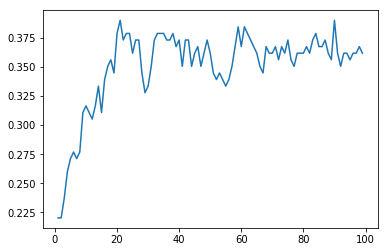

In [133]:
#kを1~100まで変えて、その時の精度を可視化(標準化無し)
import matplotlib.pyplot as plt
accuracy = []
k_range = []
p = 1
for k in range(1, 100):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', algorithm='auto', p=p) # インスタンス生成。
    knn.fit(X_train2, Y_train_t1)                 # モデル作成実行
    Y_pred_t1 = knn.predict(X_test2)  # 予測実行
    
    knn2 = KNeighborsClassifier(n_neighbors=k, weights='distance', algorithm='auto', p=p) # インスタンス生成。
    knn2.fit(X_train2, Y_train_t2)                 # モデル作成実行
    Y_pred_t2 = knn2.predict(X_test2)  # 予測実行

    acc = acjapan(Y_test, Y_pred_t1, Y_pred_t2)
    accuracy.append(acc) # 精度格納
    k_range.append(k)
    
plt.plot(k_range, accuracy)

In [134]:
#グラフの最も高い精度とその時のk
max_acc = max(accuracy)
k_ind = accuracy.index(max_acc)
print("k=",k_range[k_ind],"\nmax_accuracy=",max_acc)

k= 21 
max_accuracy= 0.3898305084745763


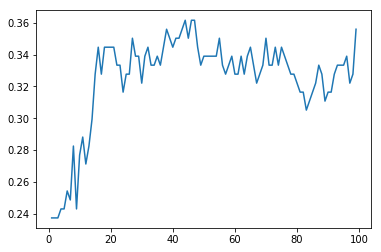

In [128]:
#標準化有りversion
accuracy = []
k_range = []
p = 1
for k in range(1, 100):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', algorithm='auto', p=p) # インスタンス生成。
    knn.fit(X_train_std, Y_train_t1)                 # モデル作成実行
    Y_pred_t1 = knn.predict(X_test_std)  # 予測実行
    
    knn2 = KNeighborsClassifier(n_neighbors=k, weights='distance', algorithm='auto', p=p) # インスタンス生成。
    knn2.fit(X_train_std, Y_train_t2)                 # モデル作成実行
    Y_pred_t2 = knn2.predict(X_test_std)  # 予測実行

    acc = acjapan(Y_test, Y_pred_t1, Y_pred_t2)
    accuracy.append(acc) # 精度格納
    k_range.append(k)

plt.plot(k_range, accuracy)

In [131]:
max_acc = max(accuracy)
k_ind = accuracy.index(max_acc)
print("k=",k_range[k_ind],"\nmax_accuracy=",max_acc)

k= 44 
max_accuracy= 0.3615819209039548
